## Imports

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt') # one time execution
import re
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package punkt to /home/vasil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Read dataset

In [2]:
df = pd.read_csv('../../WikiHow-Dataset/wikihowAll.csv', delimiter=',')

In [3]:
df.head()

,headline,title,text
0,"\nKeep related supplies in the same area.,\nMa...",How to Be an Organized Artist1,"If you're a photographer, keep all the necess..."
1,\nCreate a sketch in the NeoPopRealist manner ...,How to Create a Neopoprealist Art Work,See the image for how this drawing develops s...
2,"\nGet a bachelor’s degree.,\nEnroll in a studi...",How to Be a Visual Effects Artist1,It is possible to become a VFX artist without...
3,\nStart with some experience or interest in ar...,How to Become an Art Investor,The best art investors do their research on t...
4,"\nKeep your reference materials, sketches, art...",How to Be an Organized Artist2,"As you start planning for a project or work, ..."


In [4]:
df=df.dropna()

## Generate word embeddings

### GloVe word representations 

In [10]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2023-02-06 22:51:25--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-02-06 22:51:26--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-02-06 22:51:27--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [5]:
word_embeddings = {}
f = open('glove.6B.50d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

### SVD word embeddings

In [6]:
from nltk.corpus import PlaintextCorpusReader
import sys
import random
import math
import pprint

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import numpy as np
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import TruncatedSVD

In [7]:
def extractDictionary(corpus, limit=5000):
    dictionary = {}
    for doc in corpus:
        for w in doc:
            if w not in dictionary: dictionary[w] = 0
            dictionary[w] += 1
    L = sorted([(w,dictionary[w]) for w in dictionary], key = lambda x: x[1] , reverse=True)
    print("Dictionary has size: ", len(dictionary))
    if limit > len(L): limit = len(L)
    words = [ w for w,_ in L[:limit] ]
    word2ind = { w:i for i,w in enumerate(words)}
    return words, word2ind

In [8]:
def co_occurrence_matrix(corpus, window_size=4, limit=5000):
    words, word2ind = extractDictionary(corpus,limit=limit)
    num_words = len(words)
    
    X=np.zeros((num_words,num_words))
    
    for doc in corpus:
        for wi in range(len(doc)):
            if doc[wi] not in word2ind: continue
            i=word2ind[doc[wi]]
            for k in range(1,window_size+1):
                if wi-k>=0 and doc[wi-k] in word2ind:
                    j=word2ind[doc[wi-k]]
                    X[i,j] += 1
                if wi+k<len(doc) and doc[wi+k] in word2ind:
                    j=word2ind[doc[wi+k]]
                    X[i,j] += 1
    return X, words, word2ind

In [9]:
def SVD_k_dim(X, k=100, n_iters = 10):
    print("Running Truncated SVD over %i words..." % (X.shape[0]))
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    svd.fit(X)
    X_reduced = svd.transform(X)
    print("Done.")
    return X_reduced

In [10]:
def plot_embeddings(M, word2ind, words):
    xs = M[:,0]
    ys = M[:,1]
    for w in words:
        i=word2ind[w]
        plt.scatter(xs[i],ys[i], marker='x', color= 'red')
        plt.text(xs[i]+0.001, ys[i]+0.001, w)
    plt.show()

In [11]:
def plot_embeddings_3d(M, word2ind, words):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    xs = M[:,0]
    ys = M[:,1]
    zs = M[:,2]
    for w in words:
        i=word2ind[w]
        ax.scatter(xs[i], ys[i], zs[i], marker='x', color= 'red')
        ax.text(xs[i]+0.001, ys[i]+0.001, zs[i]+0.001, w)
    plt.show()


In [12]:
def generateArticlesAsSingleString(articles):
    return "\n".join(articles)        

## Text preprocessing

In [13]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/vasil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

def preprocess_text(text):
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    text = text.lower()
    text = nltk.word_tokenize(text)
    text = [lemmatizer.lemmatize(stemmer.stem(word)) for word in text if word not in stop_words and word.isalpha()]
    return text

[nltk_data] Downloading package wordnet to /home/vasil/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/vasil/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [15]:
def sent_tokenize_summaries(summary):
    summary = re.sub(r'[.]+[,]+[\n]', ".\n", summary)
    return sent_tokenize(summary)


## TextRank algorithm

In [16]:
def similarity_matrix(documents):
    similarity = np.zeros((len(documents), len(documents)))
    for i in range(len(documents)):
        for j in range(len(documents)):
            if i != j:
                similarity[i][j] = cosine_similarity(documents[i].reshape(1,50), documents[j].reshape(1,50))[0,0]
    return similarity

In [17]:
def generate_sentence_vectors(preprocessed_sentences):
    sentence_vectors = []
    for i in preprocessed_sentences:
      if len(i) != 0:
        v = sum([word_embeddings.get(w, np.zeros((50,))) for w in i])/(len(i)+0.001)
      else:
        v = np.zeros((50,))
      sentence_vectors.append(v)
    return sentence_vectors

In [18]:
def generate_sentence_vectors_CC(preprocessed_sentences):
    sentence_vectors = []
    for i in preprocessed_sentences:
      if len(i) != 0:
        v = sum([CC_reduced[ccwi.get(w, 0)] for w in i])/(len(i)+0.001)
      else:
        v = np.zeros((50,))
      sentence_vectors.append(v)
    return sentence_vectors

In [19]:
def text_rank(text):
    sentences = sent_tokenize(text)
    preprocessed_sentences = [preprocess_text(sentence) for sentence in sentences]
    sentence_vectors = generate_sentence_vectors_CC(preprocessed_sentences) 
    similarity = similarity_matrix(sentence_vectors)
    graph = nx.from_numpy_array(similarity)
    scores = nx.pagerank(graph, max_iter=2000)
    ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)
    return ranked_sentences

In [20]:
def summarize(text, n=7):
    ranked_sentences = text_rank(text)
    return [sentence for score, sentence in ranked_sentences[:n]]

## Evaluation

In [21]:
from rouge import Rouge

def evaluate_rouge_score(reference_summaries, generated_summaries):
    rouge_scores = []
    for reference_summary, generated_summary in zip(reference_summaries, generated_summaries):
        reference_summary = ' '.join(reference_summary)
        generated_summary = ' '.join(generated_summary)
        rouge_scores.append(Rouge().get_scores(generated_summary, reference_summary, avg=True))
    return rouge_scores    


## Generate and evaluate summaries on the WikiHow dataset

In [22]:
headlines = []
articles = []
i = 0
for index, row in df.iterrows():
    abstract = row['headline']
    article = row['text']
    if i > 1000:
        break
    if isinstance(article, str) and isinstance(abstract, str):
        if len(abstract) < (0.75 * len(article)):
            # remove extra commas in abstracts
            abstract = re.sub(r'[.]+[,]+[\n]', ".\n", abstract)
            abstract = abstract.replace(".,", ".")
            # remove extra commas in articles
            article = re.sub(r'[.]+[\n]+[,]', ".\n", article)
            
            headlines.append(abstract)
            articles.append(article)
            i+=1
print("Total number of documents: ", i)

Total number of documents:  1001


Dictionary has size:  35166
Running Truncated SVD over 1000 words...
Done.


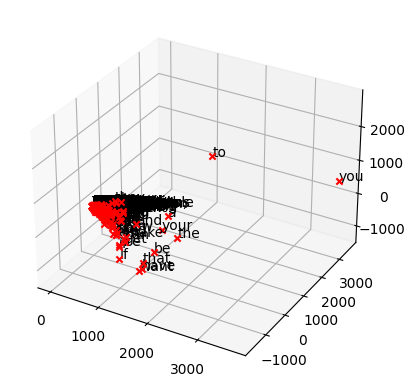

In [23]:
text = generateArticlesAsSingleString(articles)

CC,ccww,ccwi = co_occurrence_matrix([text.split()], window_size=1, limit=1000)
CC_reduced = SVD_k_dim(CC,k=50)
plot_embeddings_3d(CC_reduced, ccwi, ccww)

In [24]:
reference_summaries = [sent_tokenize_summaries(summary) for summary in headlines]
print("Generating summaries")

generated_summaries = [summarize(text) for text in articles]

print("Evaluating rouge scores")
# Evaluate the generated summaries using the ROUGE score
rouge_scores = evaluate_rouge_score(reference_summaries, generated_summaries)

total_precision = 0

total_recall = 0

total_f = 0

for k in rouge_scores:
    total_precision += k['rouge-1']['p']
    total_recall += k['rouge-1']['r']
    total_f += k['rouge-1']['f']

print('average rouge score precision:', total_precision / 1001)
print('average rouge score recall:', total_recall / 1001)
print('average rouge score f :', total_f / 1001)

Generating summaries
Evaluating rouge scores
average rouge score precision: 0.14129375180520812
average rouge score recall: 0.4014917873784638
average rouge score f : 0.19247937442899105


## Tests

In [94]:
print(headlines[0])
print(df['headline'][0])


Keep related supplies in the same area.
Make an effort to clean a dedicated workspace after every session.
Place loose supplies in large, clearly visible containers.
Use clotheslines and clips to hang sketches, photos, and reference material.
Use every inch of the room for storage, especially vertical space.
Use chalkboard paint to make space for drafting ideas right on the walls.
Purchase a label maker to make your organization strategy semi-permanent.
Make a habit of throwing out old, excess, or useless stuff each month.

Keep related supplies in the same area.,
Make an effort to clean a dedicated workspace after every session.,
Place loose supplies in large, clearly visible containers.,
Use clotheslines and clips to hang sketches, photos, and reference material.,
Use every inch of the room for storage, especially vertical space.,
Use chalkboard paint to make space for drafting ideas right on the walls.,
Purchase a label maker to make your organization strategy semi-permanent.,
Make

In [ ]:
reference_summaries = [sent_tokenize_summaries(df['headline'][0])]
generated_summaries = [summarize(df['text'][0])]

print(df['headline'][0])
print("---------------------------------------------")
print(df['text'][0])
print("---------------------------------------------")
print(reference_summaries)
print("---------------------------------------------")
print(generated_summaries)
print("---------------------------------------------")
# Evaluate the generated summaries using the ROUGE score
rouge_score = evaluate_rouge_score(reference_summaries, generated_summaries)
print('ROUGE score:', rouge_score)

In [ ]:
preprocess_text(df['text'][0])

In [75]:
word_embeddings['the']

array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01],
      dtype=float32)